In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import os, sys
import glob
import warnings
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from joblib import Parallel, delayed

import skimage

import fastai
from fastai.vision import *
from fastai.vision.models import *

from models import model_list
from utils.databunch import *
from modules.metrics import *

from submission import config, get_dataloader, UnetMxResnet, load_weights, post_process, mask2rle, stitch_preds

In [3]:
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [4]:
def dice_channel_torch(probability, truth, threshold):
    batch_size = truth.shape[0]
    channel_num = truth.shape[1]
    mean_dice_channel = 0.
    with torch.no_grad():
        for i in range(batch_size):
            for j in range(channel_num):
                channel_dice = dice_single_channel(probability[i, j,:,:], truth[i, j, :, :], threshold)
                mean_dice_channel += channel_dice/(batch_size * channel_num)
    return mean_dice_channel


def dice_single_channel(probability, truth, threshold, eps = 1E-9):
    p = (probability.view(-1) > threshold).float()
    t = (truth.view(-1) > 0.5).float()
    dice = (2.0 * (p * t).sum() + eps)/ (p.sum() + t.sum() + eps)
    return dice

def dice_single_channel_np(probability, truth, threshold, eps = 1E-9):
    p = (probability.flatten() > threshold).astype(float)
    t = (truth.flatten() > 0.5).astype(float)
    dice = (2.0 * (p * t).sum() + eps)/ (p.sum() + t.sum() + eps)
    return dice

In [5]:
split_df = pd.read_csv('./data/split.csv')
train_df = pd.read_csv('./data/train.csv')
val_df = split_df[split_df['is_valid'] == True].reset_index(drop=True)
val_imgs = set(a for a in val_df['ImageId_ClassId'])
train_df['is_valid'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0] in val_imgs)
val_df = train_df[train_df['is_valid'] == True].reset_index(drop=True)
val_df

,ImageId_ClassId,EncodedPixels,is_valid
0,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,True
1,000a4bcdd.jpg_2,NaN,True
2,000a4bcdd.jpg_3,NaN,True
3,000a4bcdd.jpg_4,NaN,True
4,0014fce06.jpg_1,NaN,True
...,...,...,...
10051,ffd0223a7.jpg_4,NaN,True
10052,ffe93442c.jpg_1,NaN,True
10053,ffe93442c.jpg_2,NaN,True
10054,ffe93442c.jpg_3,NaN,True


In [6]:
# vdl = get_dataloader(val_df, test=False)
# for batch in vdl:
#     break

In [9]:
config.exp_name = 'run1'

In [10]:
config.model_save_path()

'./model_weights/run1/best_dice.pth'

In [11]:
net = UnetMxResnet(encoder=config.unet_encoder, n_classes=config.num_classes,
                       img_size=(config.imsize, config.imsize),
                       blur=config.unet_blur, blur_final=config.unet_blur_final,
                       self_attention=config.unet_self_attention,
                       y_range=config.unet_y_range, last_cross=config.unet_last_cross, bottle=config.unet_bottle)

net = net.cuda()

net = load_weights(net, config.model_save_path())

net = net.half()
net.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): Sequential(
              (0): Conv2d(64, 64, kernel_size=

In [12]:
val_df['EncodedPixelsSubm'] = None
loaders = [get_dataloader(data_df=val_df, test=False, image_position=pos) for pos in range(7)]

allpreds = np.zeros((len(val_df), 256, 1600))

subm_idx = 0
for batches in tqdm(zip(*loaders)):
    preds = [net(b[0].cuda().half()) for b in batches]
    fpreds = stitch_preds(preds)

    for def_idx in range(4):
#         pred, num = post_process(fpreds[0,def_idx,:,:].detach().cpu().float().numpy(), config.best_threshold, config.min_size)
#         rle = mask2rle(pred)
#         val_df.loc[subm_idx, 'EncodedPixelsSubm'] = rle
        allpreds[subm_idx, ...] += fpreds[0,def_idx,:,:].detach().cpu().float().numpy()
        subm_idx+=1

In [50]:
def get_dice_from_label_rle(preds, rle, th):
    if pd.isnull(rle):
        labels = np.zeros((256, 1600))
    else:
        labels = rle2mask(rle)

    dice = dice_single_channel_np(preds, labels, th)
    return dice

def get_averge_dice(allpreds, th=0):
    dices = []
    for i, rle in enumerate(val_df['EncodedPixels']):
        dices.append(get_dice_from_label_rle(allpreds[i], rle, th))
#     dices = Parallel(n_jobs=os.cpu_count())(delayed(get_dice_from_label_rle)(i, rle, th) for i, rle in enumerate(val_df['EncodedPixels']))
    dices = np.array(dices)
    return dices.mean()

In [14]:
dices = []
ths = np.arange(0, 1.5, 0.1)
for th in tqdm(ths):
    dices.append(get_averge_dice(allpreds, th=th))
dices = np.array(dices)

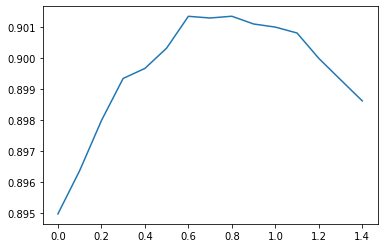

In [15]:
plt.plot(ths, dices)

In [16]:
ths[dices.argmax()]

0.8

In [20]:
dices[ths==0.5]

array([0.900329])